In [1]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.db import connect
import clease

from clease.tools import update_db
from clease import Concentration
from clease import CEBulk
from clease import Evaluate
from clease import NewStructures
from clease.calculator import Clease
from clease.calculator import attach_calculator
from ase.eos import EquationOfState
import sys
from ase.constraints import StrainFilter
from ase.optimize import BFGS
from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from clease.montecarlo.observers import ConcentrationObserver
from clease.montecarlo import SGCMonteCarlo
from clease.montecarlo import BinnedBiasPotential
from clease.montecarlo import MetaDynamicsSampler

In [3]:
#from clease.settings import CEBulk, Concentration
conc = Concentration(basis_elements=[['Ag', 'Pd']])

import json
with open('agpd_dft_eci_ref_duplication_1_18.json') as json_file: 
    eci = json.load(json_file)

conc = Concentration(basis_elements=[['Ag', 'Pd']])
settings = CEBulk(crystalstructure='fcc',
                   a=4.09,
                   size=[5,5,5],
                   concentration=conc,
                   db_name="auni_ar.db",
                   max_cluster_size=4,
                   max_cluster_dia=[8.0, 6.5, 5.5])

atoms = settings.atoms.copy()
atoms = attach_calculator(settings, atoms=atoms, eci=eci)

In [4]:
from clease.montecarlo.observers import ConcentrationObserver
obs = ConcentrationObserver(atoms, element='Ag')

In [5]:
def get_free_energy(t):
    mod = 1000
    obs = ConcentrationObserver(atoms, element='Ag')
    bias = BinnedBiasPotential(xmin=0.0 - (1.0/250), xmax=1.0 + (1.0/250), nbins=126, getter=obs)
    while mod >= 0.0005:
        obs = ConcentrationObserver(atoms, element='Ag')
        mc = SGCMonteCarlo(atoms, t, symbols=['Ag', 'Pd'])
        meta_dyn = MetaDynamicsSampler(mc=mc, bias=bias, flat_limit=0.8, mod_factor=mod,
                                       fname='agpd_metadyn.json')
        meta_dyn.run(max_sweeps=20000)
        
        
        with open('agpd_metadyn.json', 'r') as f:
            data = json.load(f)
            #print(data)
        bias.from_dict(data['bias_pot'])
        
        mod /= 2
    
    concs = np.linspace(0,1.0,126)
    new_bias_values = np.zeros((126))
    tmp = -np.asarray(bias.values)
    for i in range(126):
        new_bias_values[i] = tmp[i] - ((concs[i])*(tmp[-1]) + (1-concs[i])*(tmp[0])    )
    return new_bias_values/125.0


In [6]:
temps = np.linspace(200,900,15)

pots = np.zeros((len(temps),126))

count = 0
for t in temps:
    pots[count,:] = get_free_energy(t)
    count += 1

Starting metadynamics sampling...
Writing result to agpd_metadyn.json every 30 sec
Sweep no. 577 Average visits: 5.76e+02. Min/avg: 4.22e-01 x: 9.68e-01
Sweep no. 1120 Average visits: 1.11e+03. Min/avg: 4.30e-01 x: 2.48e-01
Sweep no. 1643 Average visits: 1.63e+03. Min/avg: 7.28e-01 x: 8.80e-01
Results from metadynamics sampling written to agpd_metadyn.json
Starting metadynamics sampling...
Writing result to agpd_metadyn.json every 30 sec
Results from metadynamics sampling written to agpd_metadyn.json
Starting metadynamics sampling...
Writing result to agpd_metadyn.json every 30 sec
Results from metadynamics sampling written to agpd_metadyn.json
Starting metadynamics sampling...
Writing result to agpd_metadyn.json every 30 sec
Results from metadynamics sampling written to agpd_metadyn.json
Starting metadynamics sampling...
Writing result to agpd_metadyn.json every 30 sec
Results from metadynamics sampling written to agpd_metadyn.json
Starting metadynamics sampling...
Writing result to a

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


200.0


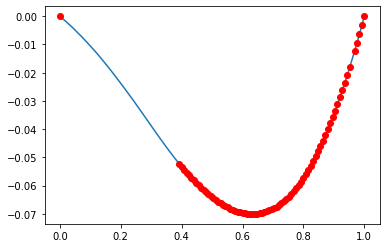

[0.0, 0.392]
250.0


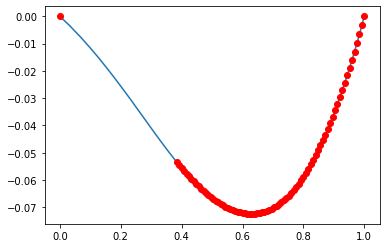

[0.0, 0.384]
300.0


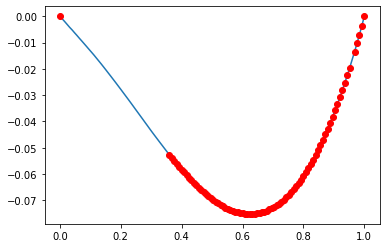

[0.0, 0.36]
350.0


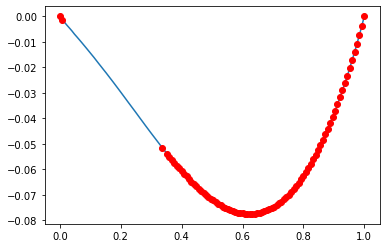

[0.008, 0.336]
400.0


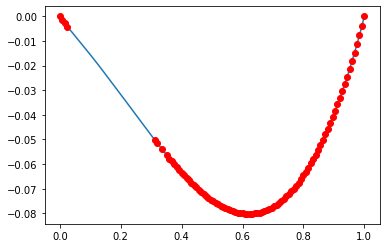

[0.024, 0.312]
450.0


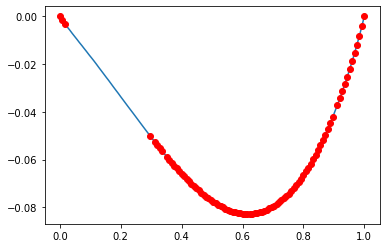

[0.016, 0.296]
500.0


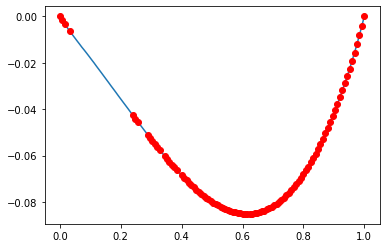

[0.032, 0.24]
550.0


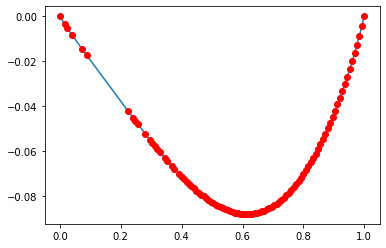

[0.088, 0.224]
600.0


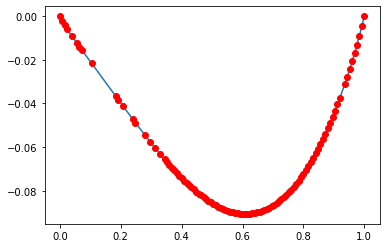

[0.10400000000000001, 0.184]
650.0


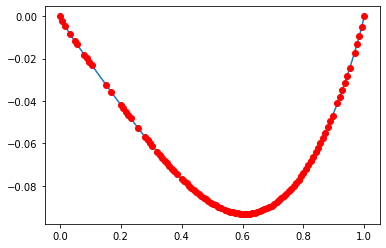

[]
700.0


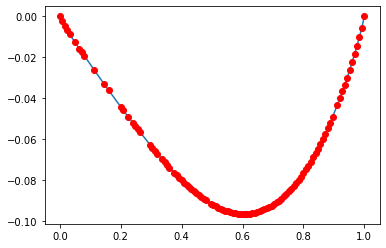

[]
750.0


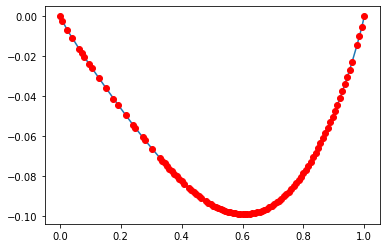

[]
800.0


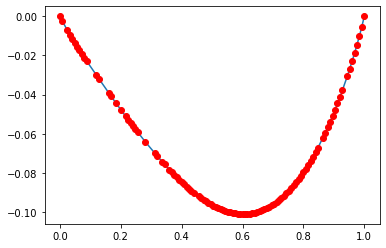

[]
850.0


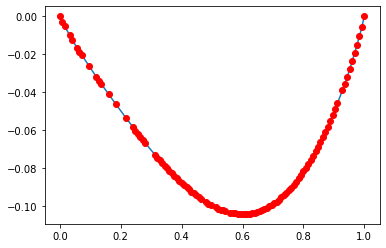

[]
900.0


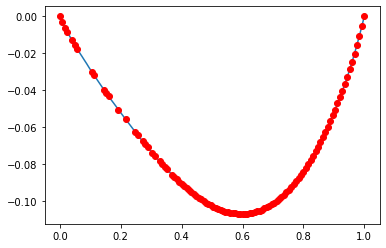

[]


In [9]:
from scipy.spatial import ConvexHull

boundaries = []

for ind in range(15):
    print(temps[ind])
    concs = np.linspace(0,1.0,126)
    plt.plot(concs,pots[ind,:])

    points = np.concatenate((concs.reshape(-1,1),pots[ind,:].reshape(-1,1)),axis = 1)
    hull = ConvexHull(points)


    plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'ro')

    plt.show()
    
    cutoff = concs[1]*8
    
    hull_points = points[hull.vertices,:]
    hull_points = np.sort(hull_points,axis=0)
    #print(hull_points)
    curr_boundary = []
    for j in range(1,hull.vertices.shape[0]):
        if (hull_points[j,0]-hull_points[j-1,0] > cutoff):
            curr_boundary.append(hull_points[j-1,0])
            curr_boundary.append(hull_points[j,0])
            
    print(curr_boundary)
    boundaries.append(curr_boundary)

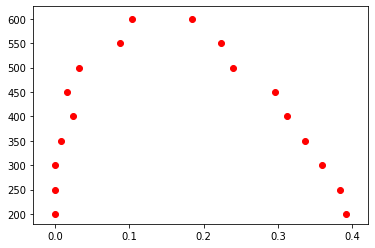

In [10]:
counter = 0
for t in temps:
    curr_temps = np.ones((len(boundaries[counter])))*t
    plt.scatter(boundaries[counter],curr_temps,color='red')
    counter += 1
    
plt.show()

In [86]:
concs_AR = np.loadtxt(open("AgPd_AR_125.csv", "rb"), delimiter=",", skiprows=0)


No handles with labels found to put in legend.


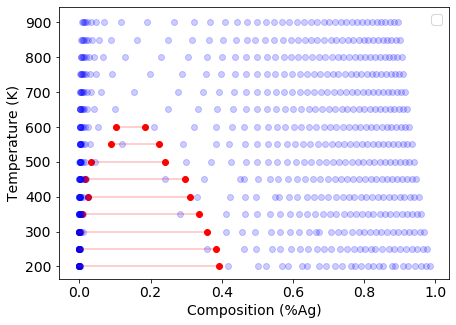

In [77]:
import matplotlib as mpl

mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}

counter = 0
for t in temps:
    curr_temps = np.ones((len(boundaries[counter])))*t
    plt.scatter(boundaries[counter],curr_temps,color='red')
    plt.plot(boundaries[counter],curr_temps,color='red',alpha=0.25)
    
    
    curr_temps = np.ones((41))*t
    plt.scatter(concs_AR[counter,:],curr_temps,color='blue',alpha=0.2)
    
    counter += 1
    
    
plt.ylabel("Temperature (K)",fontsize=14,**hfont)
plt.xlabel("Composition (%Ag)",fontsize=14,**hfont)

plt.xticks(fontsize = 14,fontname = "Arial")
plt.yticks(fontsize = 14,fontname = "Arial")
plt.legend(prop={'family': 'Arial','size':14})
#plt.savefig('AgPdMeta.png',bbox_inches='tight')
    
plt.show()

In [78]:
print(boundaries)
print(temps)
all_dat_meta_concs = []
all_dat_meta_temps = []

pos = 0
for t in temps:
    if (len(boundaries[pos]) > 0):
        all_dat_meta_temps.append(t)
        all_dat_meta_temps.append(t)
        
        all_dat_meta_concs.append(boundaries[pos][0])
        all_dat_meta_concs.append(boundaries[pos][1])
    pos+=1

[[0.0, 0.392], [0.0, 0.384], [0.0, 0.36], [0.008, 0.336], [0.024, 0.312], [0.016, 0.296], [0.032, 0.24], [0.088, 0.224], [0.10400000000000001, 0.184], [], [], [], [], [], []]
[200. 250. 300. 350. 400. 450. 500. 550. 600. 650. 700. 750. 800. 850.
 900.]


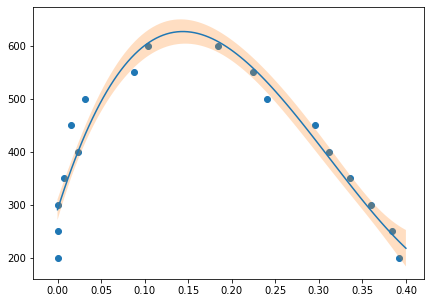

In [83]:
p_meta,C_p_meta = np.polyfit(all_dat_meta_concs, all_dat_meta_temps, 3,cov=True)



plt.scatter(all_dat_meta_concs,all_dat_meta_temps)



t = np.linspace(0.0,0.4,100)
TT = np.vstack([t**(3-i) for i in range(3+1)]).T
yi_meta = np.dot(TT, p_meta)  # matrix multiplication calculates the polynomial values
C_yi_meta = np.dot(TT, np.dot(C_p_meta, TT.T)) # C_y = TT*C_z*TT.T
sig_yi_meta = np.sqrt(np.diag(C_yi_meta))

plt.fill_between(t, yi_meta+sig_yi_meta, yi_meta-sig_yi_meta, alpha=.25)
plt.plot(t, yi_meta,'-')


#plt.plot(x,p(x))

In [94]:
plotter_concs = []
plotter_temps = []

all_dat_temps = []
all_dat_concs = []
temps_study = np.linspace(200,900,15)
counter = 0
for t in temps_study:
    if t <= 550:  
        max_diff = -1
        max_ind = -1
        for i in range(1,40):
            if (concs_AR[counter,i]- concs_AR[counter,i-1] > max_diff):
                max_diff = concs_AR[counter,i]- concs_AR[counter,i-1]
                max_ind = i
        
        plotter_temps.append([t,t])
        all_dat_temps.append(t)
        all_dat_temps.append(t)
        plotter_concs.append([concs_AR[counter,max_ind-1],concs_AR[counter,max_ind]])
        all_dat_concs.append(concs_AR[counter,max_ind-1])
        all_dat_concs.append(concs_AR[counter,max_ind])
    counter += 1

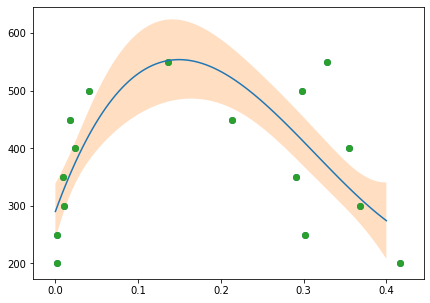

In [95]:
p_ar,C_p_ar = np.polyfit(all_dat_concs, all_dat_temps, 3,cov=True)



plt.scatter(all_dat_concs,all_dat_temps)



t = np.linspace(0.0,0.4,100)
TT = np.vstack([t**(3-i) for i in range(3+1)]).T
yi_ar = np.dot(TT, p_ar)  # matrix multiplication calculates the polynomial values
C_yi_ar = np.dot(TT, np.dot(C_p_ar, TT.T)) # C_y = TT*C_z*TT.T
sig_yi_ar = np.sqrt(np.diag(C_yi_ar))

plt.fill_between(t, yi_ar+sig_yi_ar, yi_ar-sig_yi_ar, alpha=.25)
plt.plot(t, yi_ar,'-')


plt.scatter(all_dat_concs,all_dat_temps)


In [80]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


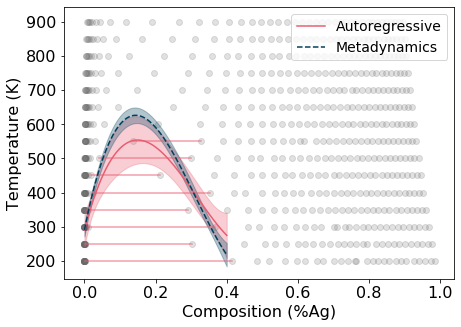

In [96]:
counter = 0
color1 = 'dimgrey'
color2 = newcmp(0.66666)
color3 = newcmp(0.0)
plt.rcParams["figure.figsize"] = (7,5)

for t in temps:
    curr_temps = np.ones((len(boundaries[counter])))*t
    #plt.scatter(boundaries[counter],curr_temps,color='red')
    #plt.plot(boundaries[counter],curr_temps,color='red',alpha=0.25)
    
    
    if t <= 550:
        holder = 1
        plt.plot(plotter_concs[counter],plotter_temps[counter],color=color2,alpha=0.60)
    curr_temps = np.ones((41))*t
    plt.scatter(concs_AR[counter,:],curr_temps,color=color1,alpha=0.2)
    
    counter += 1
    
    
plt.ylabel("Temperature (K)",fontsize=16,fontname="Arial")
plt.xlabel("Composition (%Ag)",fontsize=16,fontname="Arial")

t = np.linspace(0.0,0.4,100)

plt.fill_between(t, yi_ar+sig_yi_ar, yi_ar-sig_yi_ar, alpha=.3,color=color2)
plt.plot(t, yi_ar,'-',color=color2,label='Autoregressive')
plt.fill_between(t, yi_meta+sig_yi_meta, yi_meta-sig_yi_meta, alpha=.3,color=color3)
plt.plot(t, yi_meta,'--',color=color3,label='Metadynamics')


plt.xticks(fontsize = 16,fontname = "Arial")
plt.yticks(fontsize = 16,fontname = "Arial")
plt.legend(prop={'family': 'Arial','size':14},loc=1)
plt.savefig('AgPdMeta_June.pdf',bbox_inches='tight')
    


